In [1]:
import fancyimpute
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data1 = pd.read_csv('../TADPOLEData/ADNIMERGE.csv')

In [31]:
data1[data1['VISCODE']=='bl']['DX_bl'].value_counts()

LMCI    565
CN      413
AD      337
EMCI    312
SMC     106
Name: DX_bl, dtype: int64

In [32]:
data1.shape

(13115, 109)

In [33]:
data1 = data1[data1['VISCODE']=='bl']

In [34]:
data1.shape

(1800, 109)

In [35]:
data2=data1[data1.DX_bl!='SMC']

In [36]:
data2['DX_bl'].value_counts()

LMCI    565
CN      413
AD      337
EMCI    312
Name: DX_bl, dtype: int64

In [37]:
XY = data2[['RID','APOE4', 'FDG', 'PIB',
       'AV45', 'ABETA', 'TAU','PTAU',  
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting','LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem',
       'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan','EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'FLDSTRENG','FSVERSION',  'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV', 'mPACCdigit','mPACCtrailsB','DX_bl']]

In [38]:
def Scaling_with_null_minmax(df):

    df_min=df.copy()
    df_max=df.copy()

    df=df.as_matrix()
    df_min_np=df_min.as_matrix()
    df_max_np=df_max.as_matrix()

    df_min_np_1  = np.nanmin(df_min_np,axis=0)
    df_max_np_1= np.nanmax(df_max_np,axis=0)


    df_normalized=((df-df_min_np_1)/((df_max_np_1-df_min_np_1+(1e-6))))

    print(df_normalized)

    return df_normalized

In [39]:
XY['FSVERSION']= XY['FSVERSION'].factorize()[0]
XY['FLDSTRENG']= XY['FLDSTRENG'].factorize()[0]
le = preprocessing.LabelEncoder()
XY['FSVERSION']=le.fit_transform(XY['FSVERSION'])

In [40]:
# Dropping values which are not meaningful
# ABETHA
XY = XY.drop(XY[XY['ABETA'] =='>1700'].index)
XY = XY.drop(XY[XY['ABETA'] =='<200'].index)
# PTAU
XY['PTAU']=(XY['PTAU'].astype(str))
XY = XY.drop(XY[XY['PTAU'] =='>120'].index)
XY = XY.drop(XY[XY['PTAU'] =='<8'].index)
XY['PTAU']=(XY['PTAU'].astype(float))
# TAU
XY['TAU']=(XY['TAU'].astype(str))
XY = XY.drop(XY[XY['TAU'] =='>1300'].index)
XY = XY.drop(XY[XY['TAU'] =='<80'].index)
XY['TAU']=(XY['TAU'].astype(float))

XY = XY.drop(XY[XY['DX_bl']=='SMC'].index)
XY = XY.dropna(subset=['DX_bl'])

# redefining value types which we deal with them in the above section
# ABETA
XY['ABETA']=(XY['ABETA'].astype(float))
XY = XY.infer_objects()
# PTAU
XY['PTAU']=(XY['PTAU'].astype(float))
# TAU
XY['TAU']=(XY['TAU'].astype(float))

In [41]:
RID= XY.RID
URID=list(set(RID))
nums = np.ones(len(URID))
nums[:int(0.25*len(URID))] = 0
np.random.shuffle(nums)
#train set
p=(np.asarray(URID)*nums)
indx=[int(i) for i in p]
ix = np.isin(XY.RID, indx)
XY_train1 = XY.iloc[ix]
# Test set
nums_te =nums*(-1)+1
p=(np.asarray(URID)*nums_te)
indx=[int(i) for i in p]
ix = np.isin(XY.RID, indx)
XY_test1 = XY.iloc[ix]

In [42]:
XY['DX_bl'].unique()

array(['CN', 'AD', 'LMCI', 'EMCI'], dtype=object)

In [43]:
XY['DX_bl'].value_counts()

LMCI    533
CN      341
AD      329
EMCI    257
Name: DX_bl, dtype: int64

In [44]:
XY_train = XY_train1
XY_test = XY_test1

In [17]:
XY_train = XY_train.drop(['RID'],axis=1)
XY_test = XY_test.drop(['RID'],axis=1)

In [18]:
X_train = XY_train.iloc[:,0:-1]
y_train = XY_train.iloc[:,-1]

X_test = XY_test.iloc[:,0:-1]
y_test = XY_test.iloc[:,-1]

# enc = preprocessing.LabelEncoder()
# y_test=enc.fit_transform(y_test)
# y_train=enc.fit_transform(y_train)

X_train_Scale=Scaling_with_null_minmax(X_train)
X_test_Scale=Scaling_with_null_minmax(X_test)

X_train_scale_o = X_train_Scale.copy()
X_test_scale_o = X_test_Scale.copy()

X_train_filled = np.nan_to_num(X_train_Scale)
X_test_filled = np.nan_to_num(X_test_Scale)


class_names=np.unique(y_test)
le = preprocessing.LabelEncoder()
y_test_co=le.fit_transform(np.asarray(y_test))
y_train_co=le.fit_transform(np.asarray(y_train))


[[0.         0.66540384        nan ... 0.87556458 0.63196253 0.66349502]
 [0.49999975 0.38966558        nan ... 0.81220285 0.21491534 0.23884645]
 [0.         0.59483299        nan ... 0.53494453 0.71630318 0.75601211]
 ...
 [0.         0.41400446        nan ... 0.15328843 0.0668412  0.06916377]
 [       nan        nan        nan ... 0.49400753 0.51436245 0.49151567]
 [       nan 0.69203996        nan ... 0.68055666        nan        nan]]
[[0.                nan        nan ... 0.5983934  0.51054114 0.4416063 ]
 [0.                nan        nan ... 0.39267044 0.4471142  0.38772629]
 [0.49999975        nan        nan ... 0.25208262 0.10570617 0.07490674]
 ...
 [0.         0.63190705        nan ... 0.68717061 0.81612718 0.72172809]
 [0.         0.44718015        nan ... 0.23603791 0.32164225 0.28947085]
 [0.49999975 0.53448889        nan ... 0.69272781 0.78731976 0.80883319]]


In [19]:
class_names

array(['AD', 'CN', 'EMCI', 'LMCI'], dtype=object)

In [20]:
np.bincount(y_test_co)

array([ 91,  76,  63, 135])

In [21]:
# Binarize the output
# y1 = label_binarize(y_train, classes=[0, 1, 2 , 3])
LB = preprocessing.LabelBinarizer()
y_train_bi=LB.fit_transform(y_train_co)
y_test_bi=LB.fit_transform(y_test_co)
n_classes = y_train_bi.shape[1]

RF-NAN
0.8273972602739726
0.8326527016775257
0.8273972602739726
AD
CN
EMCI
LMCI


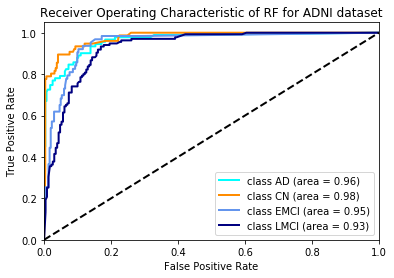

In [22]:
classifier = RandomForestClassifier(max_features=10, min_samples_leaf=1, min_samples_split=10, bootstrap=False, max_depth=None,
                             criterion='gini')
# Learn to predict each class against the other
# classifier = OneVsRestClassifier(svm.SVC(gamma= 0.0001, C= 100, kernel= 'rbf'))
y_score = classifier.fit(X_train_filled,y_train_bi).predict_proba(X_test_filled)
y_score=np.asarray(y_score)[:,:,1]
y_score=np.transpose(y_score)
classifier.fit(X_train_filled,y_train_co).predict_proba(X_test_filled)
y_pred = classifier.predict(X_test_filled)


print('RF-NAN')
print(accuracy_score(y_test_co, y_pred))
print(precision_score(y_test_co, y_pred, average='weighted'))
print(recall_score(y_test_co, y_pred, average='weighted'))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy'])
for i, color in zip(range(n_classes), colors):
    s=le.inverse_transform(i)
    print(s)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(s, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of RF for ADNI dataset')
plt.legend(loc="lower right")
plt.show()



SVM-NAN
0.6712328767123288
0.7072067718390718
0.6712328767123288


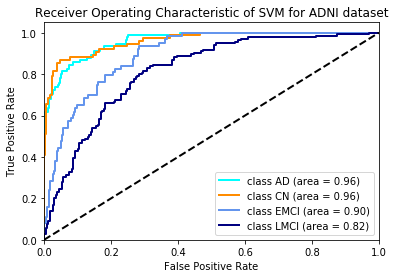

In [23]:

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(gamma= 0.0001, C= 100, kernel= 'rbf'))
y_score = classifier.fit(X_train_filled,y_train_bi).decision_function(X_test_filled)
classifier.fit(X_train_filled,y_train_co)
y_pred = classifier.predict(X_test_filled)
print('SVM-NAN')
print(accuracy_score(y_test_co, y_pred))
print(precision_score(y_test_co, y_pred, average='weighted'))
print(recall_score(y_test_co, y_pred, average='weighted'))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy'])
for i, color in zip(range(n_classes), colors):
    s=le.inverse_transform(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(s, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of SVM for ADNI dataset')
plt.legend(loc="lower right")
plt.show()



GB-NAN
0.8410958904109589
0.8487917864379276
0.8410958904109589


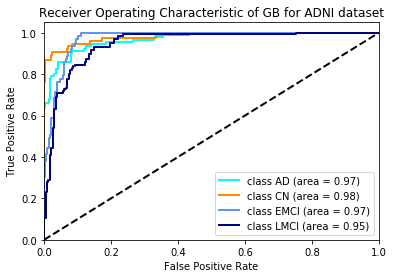

In [24]:

# Learn to predict each class against the other
clf = XGBClassifier(max_depth=5, max_features=40, subsample=0.5, min_samples_split=200, n_estimators=81,
                    min_samples_leaf=10, learning_rate=0.1)

y_score = clf.fit(X_train_Scale,y_train_co).predict_proba(X_test_Scale)
y_pred = clf.predict(X_test_Scale)
print('GB-NAN')
print(accuracy_score(y_test_co, y_pred))
print(precision_score(y_test_co, y_pred, average='weighted'))
print(recall_score(y_test_co, y_pred, average='weighted'))

# Binarize the output
y_test_gb = label_binarize(y_test_co, classes=[0, 1, 2 , 3])
n_classes = 4#y_test_gb.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy'])
for i, color in zip(range(n_classes), colors):
    s=le.inverse_transform(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(s, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of GB for ADNI dataset')
plt.legend(loc="lower right")
plt.show()



In [25]:

X_trainO = X_train_scale_o.copy()
X_testO = X_test_scale_o.copy()

X_train = KNN(k=10).complete(X_trainO)
X_test = KNN(k=10).complete(X_testO)

clf = RandomForestClassifier(max_features=10, min_samples_leaf=1, min_samples_split=10, bootstrap=False, max_depth=None,
                             criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RF-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = XGBClassifier(max_depth=5, max_features=143, subsample=0.5, min_samples_split=200, n_estimators=81,
                    min_samples_leaf=10, learning_rate=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('GB-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = svm.SVC(gamma=0.0001, C=100, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('SVM-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

Imputing row 1/1095 with 20 missing, elapsed time: 0.347
Imputing row 101/1095 with 21 missing, elapsed time: 0.378
Imputing row 201/1095 with 18 missing, elapsed time: 0.404
Imputing row 301/1095 with 17 missing, elapsed time: 0.434
Imputing row 401/1095 with 21 missing, elapsed time: 0.464
Imputing row 501/1095 with 5 missing, elapsed time: 0.487
Imputing row 601/1095 with 2 missing, elapsed time: 0.492
Imputing row 701/1095 with 3 missing, elapsed time: 0.498
Imputing row 801/1095 with 2 missing, elapsed time: 0.507
Imputing row 901/1095 with 2 missing, elapsed time: 0.526
Imputing row 1001/1095 with 2 missing, elapsed time: 0.544
Imputing row 1/365 with 18 missing, elapsed time: 0.050
Imputing row 101/365 with 18 missing, elapsed time: 0.075
Imputing row 201/365 with 3 missing, elapsed time: 0.092
Imputing row 301/365 with 22 missing, elapsed time: 0.101
RF-NAN
0.8136986301369863
0.817253672917125
0.8136986301369863
GB-NAN
0.8328767123287671
0.8383167503973625
0.8328767123287671
SV

In [26]:
X_trainO = X_train_scale_o.copy()
X_testO = X_test_scale_o.copy()

X_train = fancyimpute.IterativeSVD().complete(X_trainO)
X_test = fancyimpute.IterativeSVD().complete(X_testO)

clf = RandomForestClassifier(max_features=10, min_samples_leaf=1, min_samples_split=10, bootstrap=False, max_depth=None,
                             criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RF-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = XGBClassifier(max_depth=5, max_features=143, subsample=0.5, min_samples_split=200, n_estimators=81,
                    min_samples_leaf=10, learning_rate=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('GB-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = svm.SVC(gamma=0.0001, C=100, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('SVM-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

[IterativeSVD] Iter 1: observed MAE=0.173306
[IterativeSVD] Iter 2: observed MAE=0.131982
[IterativeSVD] Iter 3: observed MAE=0.109057
[IterativeSVD] Iter 4: observed MAE=0.074389
[IterativeSVD] Iter 5: observed MAE=0.063229
[IterativeSVD] Iter 6: observed MAE=0.062840
[IterativeSVD] Iter 7: observed MAE=0.062489
[IterativeSVD] Iter 8: observed MAE=0.062165
[IterativeSVD] Iter 9: observed MAE=0.061858
[IterativeSVD] Iter 10: observed MAE=0.061547
[IterativeSVD] Iter 11: observed MAE=0.061227
[IterativeSVD] Iter 12: observed MAE=0.060906
[IterativeSVD] Iter 13: observed MAE=0.060594
[IterativeSVD] Iter 14: observed MAE=0.060305
[IterativeSVD] Iter 15: observed MAE=0.060044
[IterativeSVD] Iter 16: observed MAE=0.059817
[IterativeSVD] Iter 17: observed MAE=0.059626
[IterativeSVD] Iter 18: observed MAE=0.059464
[IterativeSVD] Iter 19: observed MAE=0.059326
[IterativeSVD] Iter 20: observed MAE=0.059211
[IterativeSVD] Iter 21: observed MAE=0.059113
[IterativeSVD] Iter 22: observed MAE=0.0590

[IterativeSVD] Iter 16: observed MAE=0.066992
[IterativeSVD] Iter 17: observed MAE=0.066818
[IterativeSVD] Iter 18: observed MAE=0.066663
[IterativeSVD] Iter 19: observed MAE=0.066522
[IterativeSVD] Iter 20: observed MAE=0.066394
[IterativeSVD] Iter 21: observed MAE=0.066276
[IterativeSVD] Iter 22: observed MAE=0.066169
[IterativeSVD] Iter 23: observed MAE=0.066071
[IterativeSVD] Iter 24: observed MAE=0.065981
[IterativeSVD] Iter 25: observed MAE=0.065898
[IterativeSVD] Iter 26: observed MAE=0.065819
[IterativeSVD] Iter 27: observed MAE=0.065744
[IterativeSVD] Iter 28: observed MAE=0.065672
[IterativeSVD] Iter 29: observed MAE=0.065603
[IterativeSVD] Iter 30: observed MAE=0.065539
[IterativeSVD] Iter 31: observed MAE=0.065476
[IterativeSVD] Iter 32: observed MAE=0.065414
[IterativeSVD] Iter 33: observed MAE=0.065355
[IterativeSVD] Iter 34: observed MAE=0.065298
[IterativeSVD] Iter 35: observed MAE=0.065245
[IterativeSVD] Iter 36: observed MAE=0.065193
[IterativeSVD] Iter 37: observed M

GB-NAN
0.8301369863013699
0.8345466255584802
0.8301369863013699
SVM-NAN
0.7095890410958904
0.7245476833559417
0.7095890410958904


In [27]:
X_trainO = X_train_scale_o.copy()
X_testO = X_test_scale_o.copy()


X_train = fancyimpute.SoftImpute().complete(X_trainO)
X_test = fancyimpute.SoftImpute().complete(X_testO)


clf = RandomForestClassifier(max_features=10, min_samples_leaf=1, min_samples_split=10, bootstrap=False, max_depth=None,
                             criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RF-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = XGBClassifier(max_depth=5, max_features=143, subsample=0.5, min_samples_split=200, n_estimators=81,
                    min_samples_leaf=10, learning_rate=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('GB-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = svm.SVC(gamma=0.0001, C=100, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('SVM-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

[SoftImpute] Max Singular Value of X_init = 74.733063
[SoftImpute] Iter 1: observed MAE=0.035876 rank=36
[SoftImpute] Iter 2: observed MAE=0.036418 rank=36
[SoftImpute] Iter 3: observed MAE=0.036768 rank=36
[SoftImpute] Iter 4: observed MAE=0.036939 rank=35
[SoftImpute] Iter 5: observed MAE=0.037006 rank=35
[SoftImpute] Iter 6: observed MAE=0.037086 rank=35
[SoftImpute] Iter 7: observed MAE=0.037167 rank=35
[SoftImpute] Iter 8: observed MAE=0.037246 rank=35
[SoftImpute] Iter 9: observed MAE=0.037316 rank=35
[SoftImpute] Iter 10: observed MAE=0.037377 rank=35
[SoftImpute] Iter 11: observed MAE=0.037429 rank=35
[SoftImpute] Iter 12: observed MAE=0.037465 rank=34
[SoftImpute] Iter 13: observed MAE=0.037496 rank=34
[SoftImpute] Iter 14: observed MAE=0.037523 rank=34
[SoftImpute] Iter 15: observed MAE=0.037547 rank=34
[SoftImpute] Iter 16: observed MAE=0.037568 rank=34
[SoftImpute] Iter 17: observed MAE=0.037588 rank=34
[SoftImpute] Iter 18: observed MAE=0.037606 rank=34
[SoftImpute] Iter 1

[SoftImpute] Iter 85: observed MAE=0.038206 rank=34
[SoftImpute] Iter 86: observed MAE=0.038207 rank=34
[SoftImpute] Iter 87: observed MAE=0.038208 rank=34
[SoftImpute] Iter 88: observed MAE=0.038210 rank=34
[SoftImpute] Iter 89: observed MAE=0.038211 rank=34
[SoftImpute] Iter 90: observed MAE=0.038212 rank=34
[SoftImpute] Iter 91: observed MAE=0.038213 rank=34
[SoftImpute] Iter 92: observed MAE=0.038214 rank=34
[SoftImpute] Iter 93: observed MAE=0.038215 rank=34
[SoftImpute] Iter 94: observed MAE=0.038216 rank=34
[SoftImpute] Iter 95: observed MAE=0.038217 rank=34
[SoftImpute] Iter 96: observed MAE=0.038218 rank=34
[SoftImpute] Iter 97: observed MAE=0.038219 rank=34
[SoftImpute] Iter 98: observed MAE=0.038220 rank=34
[SoftImpute] Iter 99: observed MAE=0.038221 rank=34
[SoftImpute] Iter 100: observed MAE=0.038222 rank=34
[SoftImpute] Stopped after iteration 100 for lambda=0.858014
RF-NAN
0.821917808219178
0.8228525696569851
0.821917808219178
GB-NAN
0.8356164383561644
0.8391866601020272

In [28]:
X_trainO = X_train_scale_o.copy()
X_testO = X_test_scale_o.copy()

X_train = fancyimpute.MatrixFactorization().complete(X_trainO)
X_test = fancyimpute.MatrixFactorization().complete(X_testO)


clf = RandomForestClassifier(max_features=10, min_samples_leaf=3, min_samples_split=2, bootstrap=False, max_depth=None,
                             criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RF-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = XGBClassifier(max_depth=2, max_features=30, subsample=0.5, min_samples_split=200, n_estimators=81,
                    min_samples_leaf=10, learning_rate=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('GB-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

clf = svm.SVC(gamma=0.0001, C=100, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('SVM-NAN')
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

Train on 27346 samples, validate on 3039 samples
Epoch 1/10000
 - 0s - loss: 1.1223 - val_loss: 1.0737
Epoch 2/10000
 - 0s - loss: 1.1199 - val_loss: 1.0730
Epoch 3/10000
 - 0s - loss: 1.1180 - val_loss: 1.0724
Epoch 4/10000
 - 0s - loss: 1.1164 - val_loss: 1.0717
Epoch 5/10000
 - 0s - loss: 1.1147 - val_loss: 1.0711
Epoch 6/10000
 - 0s - loss: 1.1130 - val_loss: 1.0704
Epoch 7/10000
 - 0s - loss: 1.1113 - val_loss: 1.0697
Epoch 8/10000
 - 0s - loss: 1.1095 - val_loss: 1.0690
Epoch 9/10000
 - 0s - loss: 1.1077 - val_loss: 1.0683
Epoch 10/10000
 - 0s - loss: 1.1059 - val_loss: 1.0676
Epoch 11/10000
 - 0s - loss: 1.1040 - val_loss: 1.0669
Epoch 12/10000
 - 0s - loss: 1.1022 - val_loss: 1.0661
Epoch 13/10000
 - 0s - loss: 1.1003 - val_loss: 1.0654
Epoch 14/10000
 - 0s - loss: 1.0984 - val_loss: 1.0647
Epoch 15/10000
 - 0s - loss: 1.0965 - val_loss: 1.0639
Epoch 16/10000
 - 0s - loss: 1.0946 - val_loss: 1.0632
Epoch 17/10000
 - 0s - loss: 1.0926 - val_loss: 1.0624
Epoch 18/10000
 - 0s - lo

Epoch 149/10000
 - 0s - loss: 0.8238 - val_loss: 0.9001
Epoch 150/10000
 - 0s - loss: 0.8213 - val_loss: 0.8981
Epoch 151/10000
 - 0s - loss: 0.8187 - val_loss: 0.8961
Epoch 152/10000
 - 0s - loss: 0.8162 - val_loss: 0.8941
Epoch 153/10000
 - 0s - loss: 0.8136 - val_loss: 0.8921
Epoch 154/10000
 - 0s - loss: 0.8111 - val_loss: 0.8901
Epoch 155/10000
 - 0s - loss: 0.8085 - val_loss: 0.8881
Epoch 156/10000
 - 0s - loss: 0.8060 - val_loss: 0.8860
Epoch 157/10000
 - 0s - loss: 0.8034 - val_loss: 0.8840
Epoch 158/10000
 - 0s - loss: 0.8009 - val_loss: 0.8820
Epoch 159/10000
 - 0s - loss: 0.7983 - val_loss: 0.8800
Epoch 160/10000
 - 0s - loss: 0.7958 - val_loss: 0.8780
Epoch 161/10000
 - 0s - loss: 0.7932 - val_loss: 0.8760
Epoch 162/10000
 - 0s - loss: 0.7907 - val_loss: 0.8739
Epoch 163/10000
 - 0s - loss: 0.7881 - val_loss: 0.8719
Epoch 164/10000
 - 0s - loss: 0.7856 - val_loss: 0.8699
Epoch 165/10000
 - 0s - loss: 0.7831 - val_loss: 0.8679
Epoch 166/10000
 - 0s - loss: 0.7805 - val_loss:

Epoch 296/10000
 - 0s - loss: 0.5363 - val_loss: 0.6913
Epoch 297/10000
 - 0s - loss: 0.5351 - val_loss: 0.6906
Epoch 298/10000
 - 0s - loss: 0.5339 - val_loss: 0.6899
Epoch 299/10000
 - 0s - loss: 0.5326 - val_loss: 0.6892
Epoch 300/10000
 - 0s - loss: 0.5314 - val_loss: 0.6884
Epoch 301/10000
 - 0s - loss: 0.5302 - val_loss: 0.6878
Epoch 302/10000
 - 0s - loss: 0.5290 - val_loss: 0.6870
Epoch 303/10000
 - 0s - loss: 0.5278 - val_loss: 0.6864
Epoch 304/10000
 - 0s - loss: 0.5266 - val_loss: 0.6857
Epoch 305/10000
 - 0s - loss: 0.5255 - val_loss: 0.6850
Epoch 306/10000
 - 0s - loss: 0.5243 - val_loss: 0.6843
Epoch 307/10000
 - 0s - loss: 0.5231 - val_loss: 0.6836
Epoch 308/10000
 - 0s - loss: 0.5220 - val_loss: 0.6829
Epoch 309/10000
 - 0s - loss: 0.5208 - val_loss: 0.6823
Epoch 310/10000
 - 0s - loss: 0.5196 - val_loss: 0.6816
Epoch 311/10000
 - 0s - loss: 0.5185 - val_loss: 0.6810
Epoch 312/10000
 - 0s - loss: 0.5173 - val_loss: 0.6803
Epoch 313/10000
 - 0s - loss: 0.5162 - val_loss:

Epoch 443/10000
 - 0s - loss: 0.3970 - val_loss: 0.6125
Epoch 444/10000
 - 0s - loss: 0.3962 - val_loss: 0.6121
Epoch 445/10000
 - 0s - loss: 0.3955 - val_loss: 0.6117
Epoch 446/10000
 - 0s - loss: 0.3947 - val_loss: 0.6113
Epoch 447/10000
 - 0s - loss: 0.3940 - val_loss: 0.6109
Epoch 448/10000
 - 0s - loss: 0.3933 - val_loss: 0.6105
Epoch 449/10000
 - 0s - loss: 0.3925 - val_loss: 0.6101
Epoch 450/10000
 - 0s - loss: 0.3918 - val_loss: 0.6097
Epoch 451/10000
 - 0s - loss: 0.3911 - val_loss: 0.6093
Epoch 452/10000
 - 0s - loss: 0.3904 - val_loss: 0.6089
Epoch 453/10000
 - 0s - loss: 0.3896 - val_loss: 0.6085
Epoch 454/10000
 - 0s - loss: 0.3889 - val_loss: 0.6081
Epoch 455/10000
 - 0s - loss: 0.3882 - val_loss: 0.6078
Epoch 456/10000
 - 0s - loss: 0.3875 - val_loss: 0.6073
Epoch 457/10000
 - 0s - loss: 0.3868 - val_loss: 0.6070
Epoch 458/10000
 - 0s - loss: 0.3860 - val_loss: 0.6066
Epoch 459/10000
 - 0s - loss: 0.3853 - val_loss: 0.6062
Epoch 460/10000
 - 0s - loss: 0.3846 - val_loss:

Epoch 2/10000
 - 0s - loss: 1.0904 - val_loss: 1.0847
Epoch 3/10000
 - 0s - loss: 1.0887 - val_loss: 1.0841
Epoch 4/10000
 - 0s - loss: 1.0871 - val_loss: 1.0836
Epoch 5/10000
 - 0s - loss: 1.0855 - val_loss: 1.0830
Epoch 6/10000
 - 0s - loss: 1.0839 - val_loss: 1.0824
Epoch 7/10000
 - 0s - loss: 1.0823 - val_loss: 1.0818
Epoch 8/10000
 - 0s - loss: 1.0806 - val_loss: 1.0812
Epoch 9/10000
 - 0s - loss: 1.0789 - val_loss: 1.0806
Epoch 10/10000
 - 0s - loss: 1.0772 - val_loss: 1.0800
Epoch 11/10000
 - 0s - loss: 1.0754 - val_loss: 1.0793
Epoch 12/10000
 - 0s - loss: 1.0737 - val_loss: 1.0787
Epoch 13/10000
 - 0s - loss: 1.0719 - val_loss: 1.0780
Epoch 14/10000
 - 0s - loss: 1.0701 - val_loss: 1.0774
Epoch 15/10000
 - 0s - loss: 1.0682 - val_loss: 1.0767
Epoch 16/10000
 - 0s - loss: 1.0664 - val_loss: 1.0761
Epoch 17/10000
 - 0s - loss: 1.0646 - val_loss: 1.0754
Epoch 18/10000
 - 0s - loss: 1.0628 - val_loss: 1.0748
Epoch 19/10000
 - 0s - loss: 1.0609 - val_loss: 1.0741
Epoch 20/10000
 - 

 - 0s - loss: 0.8040 - val_loss: 0.9004
Epoch 151/10000
 - 0s - loss: 0.8016 - val_loss: 0.8983
Epoch 152/10000
 - 0s - loss: 0.7992 - val_loss: 0.8962
Epoch 153/10000
 - 0s - loss: 0.7968 - val_loss: 0.8941
Epoch 154/10000
 - 0s - loss: 0.7944 - val_loss: 0.8920
Epoch 155/10000
 - 0s - loss: 0.7921 - val_loss: 0.8899
Epoch 156/10000
 - 0s - loss: 0.7897 - val_loss: 0.8878
Epoch 157/10000
 - 0s - loss: 0.7873 - val_loss: 0.8857
Epoch 158/10000
 - 0s - loss: 0.7849 - val_loss: 0.8836
Epoch 159/10000
 - 0s - loss: 0.7825 - val_loss: 0.8816
Epoch 160/10000
 - 0s - loss: 0.7801 - val_loss: 0.8795
Epoch 161/10000
 - 0s - loss: 0.7777 - val_loss: 0.8774
Epoch 162/10000
 - 0s - loss: 0.7754 - val_loss: 0.8753
Epoch 163/10000
 - 0s - loss: 0.7730 - val_loss: 0.8733
Epoch 164/10000
 - 0s - loss: 0.7706 - val_loss: 0.8712
Epoch 165/10000
 - 0s - loss: 0.7682 - val_loss: 0.8691
Epoch 166/10000
 - 0s - loss: 0.7659 - val_loss: 0.8671
Epoch 167/10000
 - 0s - loss: 0.7635 - val_loss: 0.8650
Epoch 16

Epoch 297/10000
 - 0s - loss: 0.5374 - val_loss: 0.6996
Epoch 298/10000
 - 0s - loss: 0.5362 - val_loss: 0.6989
Epoch 299/10000
 - 0s - loss: 0.5350 - val_loss: 0.6982
Epoch 300/10000
 - 0s - loss: 0.5339 - val_loss: 0.6975
Epoch 301/10000
 - 0s - loss: 0.5327 - val_loss: 0.6969
Epoch 302/10000
 - 0s - loss: 0.5316 - val_loss: 0.6962
Epoch 303/10000
 - 0s - loss: 0.5304 - val_loss: 0.6956
Epoch 304/10000
 - 0s - loss: 0.5293 - val_loss: 0.6949
Epoch 305/10000
 - 0s - loss: 0.5282 - val_loss: 0.6943
Epoch 306/10000
 - 0s - loss: 0.5270 - val_loss: 0.6936
Epoch 307/10000
 - 0s - loss: 0.5259 - val_loss: 0.6930
Epoch 308/10000
 - 0s - loss: 0.5248 - val_loss: 0.6924
Epoch 309/10000
 - 0s - loss: 0.5237 - val_loss: 0.6917
Epoch 310/10000
 - 0s - loss: 0.5226 - val_loss: 0.6911
Epoch 311/10000
 - 0s - loss: 0.5215 - val_loss: 0.6905
Epoch 312/10000
 - 0s - loss: 0.5204 - val_loss: 0.6899
Epoch 313/10000
 - 0s - loss: 0.5193 - val_loss: 0.6892
Epoch 314/10000
 - 0s - loss: 0.5182 - val_loss:

Epoch 444/10000
 - 0s - loss: 0.4007 - val_loss: 0.6267
Epoch 445/10000
 - 0s - loss: 0.3999 - val_loss: 0.6263
Epoch 446/10000
 - 0s - loss: 0.3992 - val_loss: 0.6260
Epoch 447/10000
 - 0s - loss: 0.3984 - val_loss: 0.6256
Epoch 448/10000
 - 0s - loss: 0.3976 - val_loss: 0.6253
Epoch 449/10000
 - 0s - loss: 0.3969 - val_loss: 0.6249
Epoch 450/10000
 - 0s - loss: 0.3961 - val_loss: 0.6246
Epoch 451/10000
 - 0s - loss: 0.3953 - val_loss: 0.6243
Epoch 452/10000
 - 0s - loss: 0.3946 - val_loss: 0.6239
Epoch 453/10000
 - 0s - loss: 0.3938 - val_loss: 0.6236
Epoch 454/10000
 - 0s - loss: 0.3931 - val_loss: 0.6232
Epoch 455/10000
 - 0s - loss: 0.3923 - val_loss: 0.6229
Epoch 456/10000
 - 0s - loss: 0.3916 - val_loss: 0.6226
Epoch 457/10000
 - 0s - loss: 0.3908 - val_loss: 0.6222
Epoch 458/10000
 - 0s - loss: 0.3901 - val_loss: 0.6219
Epoch 459/10000
 - 0s - loss: 0.3894 - val_loss: 0.6216
Epoch 460/10000
 - 0s - loss: 0.3886 - val_loss: 0.6213
Epoch 461/10000
 - 0s - loss: 0.3879 - val_loss: